# Assignment 3 — Monte Carlo DNA Volume & Accessible Volume 



- Course / Assignment: Assignment 3 (Deadline: 9. November, 23:59)
- Group Members: 


## Administrative


### Individual Contributions
_(Replace this with a brief breakdown if working in a group.)_
- Name A: ...
- Name B: ...
- Name C: ...


## How to Use This Notebook

- Put **all your functions/classes** in a separate Python file, e.g., `project_lib.py`.
- In this notebook, **import** and **use** those functions to complete each task.
- Keep each task in its **own cell(s)** to match grading.
- Add **asserts** and **unit tests** (bonus points).
- Keep the notebook **concise** (bonus points). Comments and asserts don’t count toward line limit.


## Setup

> Install any missing packages in your environment first (e.g., `numpy`, `matplotlib`).

In [114]:
# Standard imports — extend as needed
# (Do NOT implement task logic here; only imports and minimal config.)

import os
from math import isclose
import random
from typing import Tuple, Iterable, List
from project_lib import SimulationBox3D, random_sphere_in_box, Sphere

# Numerical & plotting (if you use them)
import numpy as np
import matplotlib.pyplot as plt

# Project module (you write all logic here)
# from project_lib import (
#     # add your functions here as you implement them in project_lib.py
# )

# Optional: configure matplotlib defaults if desired
# plt.rcParams["figure.dpi"] = 120
# %matplotlib inline  # Uncomment if running locally in classic Jupyter

### Data Path

Set the relative or absolute path to the provided DNA coordinates file (`dna_coords.txt`).

In [115]:
# TODO: Set your data path
DNA_COORDS_PATH = "dna_coords.txt"  # Adjust if needed

# Optional: quick existence check
# assert os.path.exists(DNA_COORDS_PATH), f"File not found: {DNA_COORDS_PATH}" 

## Code Quality (Bonus)

- Run `pylint` on your `project_lib.py` for a bonus score (0–10 from pylint).
- Add `assert` statements in functions (up to +5).
- Add up to **5 test functions** (max +5).

In [116]:
# RELOAD BLOCK TO GET IMPORTS TO WORK
from importlib import reload
import project_lib
reload(project_lib)

from project_lib import (
    SimulationBox3D, Sphere,
    random_sphere_in_box,
    estimate_fraction_inside_sphere, sphere_volume
)
import matplotlib.pyplot as plt

# Set random seed for reproducibility
rng = np.random.default_rng(123)


# TOPIC 1: Calculate DNA Volume via Monte Carlo Simulation

## Task 0: Define the simulation box (x, y, z)

In [117]:

# Box ranges
x_range = (0.0, 100.0)
y_range = (0.0, 100.0)
z_range = (0.0, 100.0)

# Creating box with defined ranges
box = SimulationBox3D(x_range, y_range, z_range)

# Tests for box
print(box)
print(f"Volume of the box is: {box.volume()}") #print volume of box
assert isclose(box.volume(), 1000000)
print(f"Surface area of the box is: {box.surface_area()}")
assert isclose(box.surface_area(), 60000)
print("Assert checks on Geometry is ok!")


SimulationBox dimensions:
  x: (0.0, 100.0)
  y: (0.0, 100.0)
  z: (0.0, 100.0)
Volume of the box is: 1000000.0
Surface area of the box is: 60000.0
Assert checks on Geometry is ok!


## Task 1: Function to sample a uniform random point in the box

In [118]:
# Using box from task 0: (x: (0.0, 100.0), y: (0.0, 100.0), z: (0.0, 100.0))

# Create 10 random points, assert they are inside the box, print them out
pts = box.random_point(n=10)
assert np.all((pts >= 0) & (pts <= 100))
for i, (x, y, z) in enumerate(pts, start=1):
    print(f"Point {i:2d}: ({x:.3f}, {y:.3f}, {z:.3f})")

#Uniformity check with 3000 points
pts = box.random_point(n=3000)     # shape (3000, 3)
x, y, z = pts[:,0], pts[:,1], pts[:,2]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)

#Checks if mean is close to 50 with tolerance of 5%
assert all(isclose(m, 50, rel_tol=0.05) for m in (mean_x, mean_y, mean_z))
print("Points inbound and Uniformity check cleared!")


Point  1: (42.995, 26.972, 84.556)
Point  2: (42.234, 54.336, 6.871)
Point  3: (43.266, 96.480, 43.657)
Point  4: (51.583, 95.693, 83.851)
Point  5: (24.382, 97.496, 53.939)
Point  6: (55.520, 51.238, 36.049)
Point  7: (37.561, 10.462, 59.030)
Point  8: (31.263, 26.609, 50.762)
Point  9: (63.902, 4.138, 67.100)
Point 10: (18.101, 43.360, 66.294)
Points inbound and Uniformity check cleared!


## Task 2: Place a random sphere in the box (random center & radius)

In [119]:
# Using box from task 0: (x: (0.0, 100.0), y: (0.0, 100.0), z: (0.0, 100.0))

# Sphere radius ranges
r_min = 2.0
r_max = 50.0
rng = np.random.default_rng(123)

# Create a sphere and assign center coordinates and radius to variables for testing
sphere = random_sphere_in_box(box, r_min=r_min, r_max=r_max, rng=rng)
c_x, c_y, c_z = sphere.center
r = sphere.radius

# Finding geometric limit of box
r_limit = 0.5 * min(box.xmax - box.xmin, box.ymax - box.ymin, box.zmax - box.zmin)

# Radius and center checks
assert r_min <= r <= min(r_max, r_limit), "Sampled radius out of allowed range."
assert (box.xmin + r) <= c_x <= (box.xmax - r), "Center x violates box margin."
assert (box.ymin + r) <= c_y <= (box.ymax - r), "Center y violates box margin."
assert (box.zmin + r) <= c_z <= (box.zmax - r), "Center z violates box margin."

print("Random sphere in a box:")
print(f"  center = ({c_x:.3f}, {c_y:.3f}, {c_z:.3f})")
print(f"  radius = {r:.3f}")
print("Radius and Center check asserts ok!")

Random sphere in a box:
  center = (36.394, 41.473, 40.375)
  radius = 34.753
Radius and Center check asserts ok!


## Task 3: Point-in-sphere test function

In [120]:
# Assumptions: Points on sphere boundary does not count as inside.

# Create a sphere
sphere_test = Sphere(center =(0.0, 0.0, 0.0), radius=5.0)

# Checks for different points
assert sphere_test.is_point_in_sphere((0.0, 0.0, 0.0))           # center is inside
assert sphere_test.is_point_in_sphere((1.0, 2.0, 1.0))           # point inside
assert not sphere_test.is_point_in_sphere((5.0, 0.0, 0.0))       # on boundary: does not count as inside per our assumption
assert not sphere_test.is_point_in_sphere((6.0, 0.0, 0.0))       # outside
print("Sphere inside checks ok!")

Sphere inside checks ok!


## Task 4: Monte Carlo fraction of points inside a single sphere


We check and verify if the result is correct by comparing the Monte Carlo fraction of points inside the spheres to the analytical volume ratio between the sphere and simulation box:

$
\hat{p} = \frac{N_{\text{inside}}}{N_{\text{total}}}
\qquad \text{and} \qquad
p = \frac{V_{\text{sphere}}}{V_{\text{box}}}
= \frac{\frac{4}{3}\pi r^3}{L_x L_y L_z}
$

$\hat{p}$ should converge towards $p$ 
as the number of samples $N$ increases, within the statistical uncertainty

$
\sigma_{\hat{p}} = \sqrt{\frac{\hat{p}(1 - \hat{p})}{N}}.
$


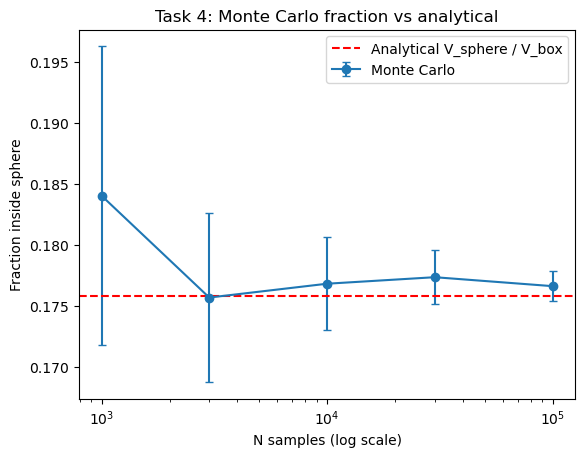

Analytical fraction: 0.175817
N=   1000  frac=0.184000  stderr≈0.012253
N=   3000  frac=0.175667  stderr≈0.006948
N=  10000  frac=0.176800  stderr≈0.003815
N=  30000  frac=0.177333  stderr≈0.002205
N= 100000  frac=0.176600  stderr≈0.001206


In [ ]:
# 1) Make a simple box and one random sphere that fits inside

rng = np.random.default_rng(123)

# 2) Monte Carlo estimates at increasing N (to show convergence)
Ns = [1_000, 3_000, 10_000, 30_000, 100_000]
estimates = []
errors = []

for N in Ns:
    frac, err = estimate_fraction_inside_sphere(box, sphere, n_samples=N, rng=rng)
    estimates.append(frac)
    errors.append(err)

# 3) Analytical fraction for sanity check
expected = sphere.volume() / box.volume()

# 4) Plot
plt.figure()
plt.errorbar(Ns, estimates, yerr=errors, fmt="o-", capsize=3, label="Monte Carlo")
plt.axhline(expected, linestyle="--", label="Analytical V_sphere / V_box", color="red")
plt.xscale("log")
plt.xlabel("N samples (log scale)")
plt.ylabel("Fraction inside sphere")
plt.title("Task 4: Monte Carlo fraction vs analytical")
plt.legend()
plt.show()

print(f"Analytical fraction: {expected:.6f}")
for N, p, se in zip(Ns, estimates, errors):
    print(f"N={N:>7d}  frac={p:.6f}  stderr≈{se:.6f}")


## Task 5: Estimate π as a function of N (sanity check)

The correctness of the Monte Carlo estimation of $\pi$ was verified by comparing 
the numerical estimate to the analytical value of $\pi$.

Random points are generated inside a square of side $d$, and the fraction that 
fall inside the inscribed circle of diameter $d$ gives an estimate

$
\hat{\pi} = 4 \times \frac{N_{\text{inside}}}{N_{\text{total}}}
$

As the number of samples $N$ increases, $\hat{\pi}$ should converge toward the 
true value of $\pi$ within the statistical uncertainty

$
\sigma_{\hat{\pi}} = 4 \sqrt{\frac{p(1 - p)}{N}},
\quad \text{where } p = \frac{N_{\text{inside}}}{N_{\text{total}}}
$

Convergence is checked by plotting $\hat{\pi}$ versus $N$ and confirming that it 
approaches $3.14159$ as $N$ grows.

In [122]:
# TODO: Use your pi_estimator function and (optionally) plot
# ns, estimates = run_pi_experiment(Ns=[...])
# plt.plot(ns, estimates); plt.axhline(math.pi)
pass

## Task 6: Generate 10 random spheres (random sizes & positions)

In [123]:
# TODO: spheres = generate_random_spheres(box, n=10, r_range=(..., ...))
# print(len(spheres))
pass

## Task 7: Monte Carlo fraction with multiple spheres

- Estimate union-of-spheres coverage via Monte Carlo.
- **Validation ideas**: compare against a voxel grid approximation, use simple non-overlapping test case, etc.

In [124]:
# TODO: fraction, stderr = estimate_fraction_inside_spheres(box, spheres, n_samples=...)
# print(fraction, stderr)
# Optional: quick plot of convergence (call your own plotting helper)
pass

## Task 8: Load DNA coordinates and map atom types to radii

- Read `dna_coords.txt` (element, x, y, z per line).
- Use a periodic table mapping (e.g., van der Waals radii) for H, C, N, O, P.
- Keep the mapping in your library module and import it here.

In [125]:
# TODO: atoms = load_dna_atoms(DNA_COORDS_PATH)  # list of (element, x, y, z)
# TODO: radii = get_element_radii()               # dict like {'H': ..., 'C': ...}
# TODO: spheres = atoms_to_spheres(atoms, radii)
pass

## Task 9: Fit/adjust the simulation box to contain the full DNA system

- Compute a tight bounding box around all atom spheres (center ± radius).
- Ensure it’s not excessively large (affects Monte Carlo efficiency).

In [126]:
# TODO: box = bounding_box_for_spheres(spheres, margin=...)
# print(box)
pass

## Task 10: Estimate DNA Volume

- Run Monte Carlo to estimate fraction of points inside **any** atom sphere.
- Volume ≈ fraction × box volume.
- **Validation**: propose checks (e.g., subsampling, voxel baseline, confidence intervals).

In [127]:
# TODO: fraction, stderr = estimate_fraction_inside_spheres(box, spheres, n_samples=...)
# TODO: dna_volume = fraction * box_volume(box)
# print(dna_volume, stderr)
# Optional: plot convergence using your helper
pass

# TOPIC 2: Random Walk for Accessible Volume Calculation

Implement a strategy to estimate accessible volume using random walkers in 3D.


## Task 1: Fast function to generate random walkers (3D)

- Start from various random initial positions.
- Keep this logic in your library and import the function(s) here.

In [128]:
# TODO: walkers = init_random_walkers(n_walkers=..., box=box, seed=...)
# print(len(walkers))
pass

## Task 3: Strategy for Accessible Volume

- Describe your strategy in Markdown here (no code required).
- You can later call your implemented functions to carry it out.

## Task 4: Validation Test

- Describe a test to verify your strategy gives plausible results.
- You can include a simple quantitative bound or comparison approach.

## Task 5: Code & Test Your Approach

In [129]:
# TODO: Run your accessible-volume experiment
# results = run_accessible_volume_experiment(...)
# print(results)
# Optional: plot summaries
pass

## (Bonus) Unit Tests & Asserts

Add small test functions or assertions to verify correctness of key utilities.
Keep it concise; aim for up to 5 tests for bonus points.


In [130]:
# Example skeletons (replace with your own tests later)
# def test_point_in_sphere_basic():
#     ...
# def test_sampling_uniformity_smoke():
#     ...
# if __name__ == "__main__":
#     test_point_in_sphere_basic()
#     test_sampling_uniformity_smoke()
#     print("Basic tests passed.")
pass

## Summary / Reflection

- Briefly summarize what you built and what you learned.
- Note any limitations or follow-ups.
